In [1]:
import numpy as np
import torch

import gpytorch

from botorch.models import FixedNoiseGP, SingleTaskGP, HeteroskedasticSingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood


from botorch.optim import optimize_acqf
import cma
from botorch.optim.fit import fit_gpytorch_torch
from scipy.optimize import minimize

from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning
import time
import warnings
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.utils.sampling import draw_sobol_samples

# import sys
# sys.path.insert(1, '/Users/trongduong/Dropbox/URP project/Code/PQC_composer')

# import qc_embedding
# from QuOTMANN import optimal_transport


from botorch.test_functions import Hartmann
neg_hartmann6 = Hartmann(dim=6,negate=True)


In [2]:
class FirstSincKernel(gpytorch.kernels.Kernel):
    # the sinc kernel is stationary
    is_stationary = True

    # this is the kernel function
    def forward(self, x1, x2, **params):
        # calculate the distance between inputs
        diff = self.covar_dist(x1, x2, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20).to(x1))
        K = torch.sin(diff).div(diff)
        #K = gpytorch.lazify(K)
        
        print('x1: ', x1)
        print('x2: ', x2)
        print(x1.shape, x2.shape, K.shape, type(K))
        print('kernel: ', K)
        return K

In [5]:
class QNN_BO():
    def __init__(self, num_qubits, MAX_OP_NODES, N_TRIALS, N_BATCH, BATCH_SIZE, MC_SAMPLES, device=None, dtype=None):
        self.num_qubits = num_qubits
        self.MAX_OP_NODES = MAX_OP_NODES
        self.encoding_length = (self.num_qubits + 1) * self.MAX_OP_NODES

        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.dtype = dtype or torch.double

        self.N_TRIALS = N_TRIALS
        self.N_BATCH = N_BATCH
        self.BATCH_SIZE = BATCH_SIZE
        self.MC_SAMPLES = MC_SAMPLES


    ## PROBLEM SETUP
    def obj_func(self, X):
        """Feasibility weighted objective"""
        print(X)
#         latent_func_values = []
#         for enc in X.detach().numpy():
#             qc = self.vec_to_circuit(vec=enc)
#             latent_func_values.append(self.latent_func(qc))
#         return latent_func_values
        Y = neg_hartmann6(X)
        return Y

    def latent_func(self,circuit):
        f = circuit.num_parameters #/ self.MAX_OP_NODES
        return torch.as_tensor(f, device=self.device, dtype=self.dtype)

    def vec_to_circuit(self,vec):
        qc = qc_embedding.enc_to_qc(num_qubits=self.num_qubits, encoding=vec)
        #print(qc.draw())
        return qc

    ## MODEL INITIALIZATION
    def generate_initial_data(self, n):
        # generate training data

        #train_x = torch.rand(n, self.encoding_length, device=self.device, dtype=self.dtype)
        train_x = draw_sobol_samples(bounds=bounds, n=n, q=1, seed=torch.randint(0, 10000, (1,)).item()).squeeze(1)

        #train_obj = [self.latent_func(self.vec_to_circuit(vec=vec)) for vec in train_x.numpy()]
        train_obj = self.obj_func(X=train_x)
        train_obj = torch.as_tensor(train_obj, device=self.device, dtype=self.dtype).unsqueeze(-1)

        best_observed_value = train_obj.max().item()
        return train_x, train_obj, best_observed_value

    def initialize_model(self, train_x, train_obj, covar_module=None, input_transform=None, state_dict=None):
        # define models for objective

        #covar_module = covar_module or gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        covar_module = covar_module or FirstSincKernel()

        model = SingleTaskGP(train_x, train_obj, covar_module=covar_module, input_transform=input_transform).to(train_x)

        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        # load state dict if it is passed
        if state_dict is not None:
            model.load_state_dict(state_dict)
        return mll, model


    ## Zero-th order optimizer of acqf


    def lbfgsb_optimize_acqf(self, acq_func, bounds):
        def neg_acq_func(x):
            X = torch.from_numpy(x).to(device=self.device, dtype=self.dtype).unsqueeze(-2)
            Y = -acq_func(X)
            y = Y.view(-1).double().numpy()
            return y

        print(bounds)
        candidates = torch.empty(size=(self.BATCH_SIZE, self.encoding_length), device=self.device, dtype=self.dtype)

        for i in range(self.BATCH_SIZE):
            with torch.no_grad():
                # get initial condition for L-BFGS-B in numpy form
                # note that L-BFGS-B expects a different shape (no explicit q-batch dimension)
                x0 = np.random.normal(loc=0.5,scale=0.4,size=self.encoding_length).clip(bounds[0].numpy(), bounds[1].numpy())
                res = minimize(fun=neg_acq_func, x0=x0, method='L-BFGS-B', bounds=np.array(list(zip(bounds[0].numpy(), bounds[1].numpy()))))
                candidates[i] = torch.from_numpy(res.x).to(candidates)
        return candidates


    ## Helper function that performs essential BO steps
    def optimize_acqf_and_get_observation(self, acq_func, bounds):
        """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
        # optimize

        #candidates = self.cmaes_optimize_acqf(acq_func=acq_func, bounds=bounds)
        candidates = self.lbfgsb_optimize_acqf(acq_func=acq_func, bounds=bounds)
        #print(candidates.shape)

        # observe new values
        new_x = unnormalize(candidates.detach(), bounds=bounds)

        #train_obj = [self.latent_func(self.vec_to_circuit(vec=vec)) for vec in new_x.numpy()]
        train_obj = self.obj_func(X=new_x)
        train_obj = torch.as_tensor(train_obj, device=self.device, dtype=self.dtype).unsqueeze(-1)

        return new_x, train_obj

    def update_random_observations(self, best_random):
        """Simulates a random policy by taking a the current list of best values observed randomly,
        drawing a new random point, observing its value, and updating the list.
        """
        #rand_x = torch.rand(BATCH_SIZE, self.encoding_length)
        rand_x = draw_sobol_samples(bounds=bounds, n=1, q=1).squeeze(1)
        next_random_best = self.obj_func(X=rand_x)
        next_random_best = torch.as_tensor(next_random_best, device=self.device, dtype=self.dtype).max().item()
        best_random.append(max(best_random[-1], next_random_best))
        return best_random

    def optimize(self, bounds):
        verbose = False

        best_observed_all_ei, best_random_all = [], []

        # average over multiple trials
        for trial in range(1, self.N_TRIALS + 1):

            print(f"\nTrial {trial:>2} of {self.N_TRIALS} ")
            best_observed_ei, best_random = [], []

            # call helper functions to generate initial training data and initialize model
            train_x_ei, train_obj_ei, best_observed_value_ei = self.generate_initial_data(n=5)
            mll_ei, model_ei = self.initialize_model(normalize(train_x_ei, bounds=bounds), standardize(train_obj_ei))

            best_observed_ei.append(best_observed_value_ei)
            best_random.append(best_observed_value_ei)
            print('data initialization: ', train_x_ei.shape, train_obj_ei.shape, best_observed_ei)

            # run n_batch rounds of BayesOpt after the initial random batch
            for iteration in range(1, self.N_BATCH + 1):
                print('iteration: ', iteration)
                t0 = time.time()
                print('fit the model')
                # fit the models
                fit_gpytorch_model(mll_ei)

                # define the qEI and qNEI acquisition modules using a QMC sampler
                qmc_sampler = SobolQMCNormalSampler(num_samples=self.MC_SAMPLES)

                # for best_f, we use the best observed noisy values as an approximation
                qEI = qExpectedImprovement(
                    model=model_ei,
                    best_f=standardize(train_obj_ei).max(),
                    sampler=qmc_sampler
                )

                print('optimize acquisition function')
                # optimize and get new observation
                new_x_ei, new_obj_ei = self.optimize_acqf_and_get_observation(acq_func=qEI, bounds=bounds)

                # update training points
                train_x_ei = torch.cat([train_x_ei, new_x_ei])
                train_obj_ei = torch.cat([train_obj_ei, new_obj_ei])
                print('temp')

                # update progress
                print('update random')
                best_random = self.update_random_observations(best_random)
                print('update qEI best value')
                best_value_ei = train_obj_ei.max().item()
                best_observed_ei.append(best_value_ei)
                print('end of batch: ', train_x_ei.shape, train_obj_ei.shape, best_observed_ei)

                # reinitialize the models so they are ready for fitting on next iteration
                # use the current state dict to speed up fitting
                mll_ei, model_ei = self.initialize_model(
                    normalize(train_x_ei, bounds=bounds),
                    standardize(train_obj_ei),
                    state_dict=model_ei.state_dict(),
                )

                t1 = time.time()

                if verbose:
                    print(
                        f"\nBatch {iteration:>2}: best_value (random, qEI) = "
                        f"({max(best_random):>4.2f}, {best_value_ei:>4.2f}), "
                        f"time = {t1 - t0:>4.2f}.", end=""
                    )
                else:
                    print(".", end="")

            best_observed_all_ei.append(best_observed_ei)
            best_random_all.append(best_random)

        return best_observed_all_ei, best_random_all


    def plot(self, kwargs):
        import numpy as np
        import matplotlib.pyplot as plt
        #plt.interactive(False)

        def ci(y):
            ## Confidence interval
            return 1.96 * y.std(axis=0) / np.sqrt(self.N_TRIALS)

        iters = np.arange(self.N_BATCH + 1) * self.BATCH_SIZE

        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        for label, best_observed_all in kwargs.items():
            y = np.asarray(best_observed_all)
            ax.errorbar(iters, y.mean(axis=0), yerr=ci(y), label=label, linewidth=1.5)
            print(label, y.mean(axis=0))


        plt.plot([0, self.N_BATCH * self.BATCH_SIZE], [1] * 2, 'k', label="true best bjective", linewidth=2)
        ax.set_ylim(bottom=0.5)
        ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
        ax.legend(loc="lower right")
        plt.plot()


Trial  1 of 1 
tensor([[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01, 3.8169e-01],
        [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01, 9.7939e-01],
        [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01, 5.3151e-01],
        [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01, 7.4684e-02],
        [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01, 3.5852e-01]],
       dtype=torch.float64)
data initialization:  torch.Size([5, 6]) torch.Size([5, 1]) [0.20777539151140798]
iteration:  1
fit the model
x1:  tensor([[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01, 3.8169e-01],
        [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01, 9.7939e-01],
        [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01, 5.3151e-01],
        [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01, 7.4684e-02],
        [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01, 3.5852e-01]],
       dtype=torch.

x1:  tensor([[[1.0000, 0.5490, 0.0363, 0.8981, 0.4601, 1.0000]]],
       dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [1.0000e+00, 5.4898e-01, 3.6331e-02, 8.9809e-01, 4.6007e-01,
          1.0000e+00]]], dtype=torch.float64)
torch.Size([1, 1, 6]) torch.Size([1, 6, 6]) torch.Size([1, 1, 6]) <class 'torch.Tensor'>
kernel:  tensor([[[0.8485, 0.7614, 0.7642, 0.7449, 0.8353, 1.0000]]],
       dtype=torch.float64)
x1:  tensor([[[1.0000, 0.5483, 0.0104, 0.8993, 0.4561, 1.0000]]],
       dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 

x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [1.0000e+00, 3.7189e-01, 0.0000e+00, 1.0000e+00, 0.0000e+00,
          1.0000e+00]]], dtype=torch.float64)
torch.Size([1, 1, 6]) torch.Size([1, 6, 6]) torch.Size([1, 1, 6]) <class 'torch.Tensor'>
kernel:  tensor([[[0.7298, 0.7832, 0.6896, 0.6679, 0.7513, 1.0000]]],
       dtype=torch.float64)
x1:  tensor([[[1.0000, 0.3719, 0.0000, 1.0000, 0.0000, 1.0000]]],
       dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5

x1:  tensor([[[0.9796, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]]],
       dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [9.7964e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00]]], dtype=torch.float64)
torch.Size([1, 1, 6]) torch.Size([1, 6, 6]) torch.Size([1, 1, 6]) <class 'torch.Tensor'>
kernel:  tensor([[[0.6843, 0.6946, 0.7665, 0.6262, 0.6285, 1.0000]]],
       dtype=torch.float64)
x1:  tensor([[[9.7964e-01, 1.0000e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00]]], dtype=torch.float64)
x2:  tensor(

x1:  tensor([[[6.4773e-02, 1.0319e-01, 1.0000e-08, 0.0000e+00, 0.0000e+00,
          1.0000e+00]]], dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [6.4773e-02, 1.0319e-01, 1.0000e-08, 0.0000e+00, 0.0000e+00,
          1.0000e+00]]], dtype=torch.float64)
torch.Size([1, 1, 6]) torch.Size([1, 6, 6]) torch.Size([1, 1, 6]) <class 'torch.Tensor'>
kernel:  tensor([[[0.6760, 0.8228, 0.8068, 0.5674, 0.5546, 1.0000]]],
       dtype=torch.float64)
x1:  tensor([[[6.4773e-02, 1.0319e-01, 0.0000e+00, 1.0000e-08, 0.0000e+00,
          1.0000e+00]]], dtype=

x1:  tensor([[[0.0000, 0.7749, 0.5491, 1.0000, 0.4895, 1.0000]]],
       dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [0.0000e+00, 7.7486e-01, 5.4911e-01, 1.0000e+00, 4.8951e-01,
          1.0000e+00]]], dtype=torch.float64)
torch.Size([1, 1, 6]) torch.Size([1, 6, 6]) torch.Size([1, 1, 6]) <class 'torch.Tensor'>
kernel:  tensor([[[0.7902, 0.8985, 0.7753, 0.7033, 0.7754, 1.0000]]],
       dtype=torch.float64)
x1:  tensor([[[0.0000, 0.7749, 0.5491, 1.0000, 0.4895, 1.0000]]],
       dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 

x1:  tensor([[[0.0000, 1.0000, 0.0000, 0.9859, 0.4122, 1.0000]]],
       dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 9.8586e-01, 4.1222e-01,
          1.0000e+00]]], dtype=torch.float64)
torch.Size([1, 1, 6]) torch.Size([1, 6, 6]) torch.Size([1, 1, 6]) <class 'torch.Tensor'>
kernel:  tensor([[[0.7838, 0.8013, 0.7540, 0.5950, 0.7101, 1.0000]]],
       dtype=torch.float64)
x1:  tensor([[[1.0000e-08, 1.0000e+00, 0.0000e+00, 9.8586e-01, 4.1222e-01,
          1.0000e+00]]], dtype=torch.float64)
x2:  tensor(

kernel:  tensor([[[0.7643, 0.6328, 0.8047, 0.7612, 0.7159, 0.7550, 0.7550, 0.6415,
          1.0000]]], dtype=torch.float64)
x1:  tensor([[[1.0000, 0.0789, 0.0000, 0.0601, 0.0354, 0.2359]]],
       dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [1.1102e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [1.0000e+00, 7.8859e-02

x1:  tensor([[[1.0000e+00, 1.0000e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00]]], dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [1.1102e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [1.0000e+00, 1.0000e-08, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00]]], dtype=torch.float64)
torch.Size([1,

x1:  tensor([[[0.8508, 0.0000, 1.0000, 0.0000, 0.6271, 1.0000]]],
       dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [1.1102e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [8.5084e-01, 0.0000e+00, 1.0000e+00, 0.0000e+00, 6.2711e-01,
          1.0000e+00]]], dtype=torch.float64)
torch.Size([1, 1, 6]) torch.Size([1, 9, 6

x1:  tensor([[[0.3546, 1.0000, 0.2687, 0.5185, 0.4791, 0.4195]]],
       dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [1.1102e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [3.5455e-01, 1.0000e+00, 2.6871e-01, 5.1853e-01, 4.7907e-01,
          4.1953e-01]]], dtype=torch.float64)
torch.Size([1, 1, 6]) torch.Size([1, 9, 6

x1:  tensor([[[0.0000, 1.0000, 0.0000, 0.9021, 0.7841, 0.0000]]],
       dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [1.1102e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 9.0207e-01, 7.8407e-01,
          0.0000e+00]]], dtype=torch.float64)
torch.Size([1, 1, 6]) torch.Size([1, 9, 6

x1:  tensor([[[0.9906, 1.0000, 0.2520, 0.6060, 0.0000, 0.2706]]],
       dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [1.1102e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000

x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [1.1102e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
          1.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e

x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [1.1102e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
          1.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e

x1:  tensor([[[0.6792, 0.9226, 0.0000, 1.0000, 0.4990, 0.5916]]],
       dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [1.1102e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000

x1:  tensor([[[0.9295, 1.0000, 0.0000, 1.0000, 0.4441, 1.0000]]],
       dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [1.1102e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000

x1:  tensor([[[1.0000e+00, 1.0000e+00, 1.0000e-08, 1.0000e+00, 3.6691e-02,
          1.0000e+00]]], dtype=torch.float64)
x2:  tensor([[[6.3399e-01, 7.4192e-01, 2.0728e-01, 4.6711e-01, 8.8984e-01,
          3.8169e-01],
         [2.9965e-02, 6.5881e-02, 5.6648e-01, 8.8075e-01, 1.5832e-01,
          9.7939e-01],
         [4.5590e-01, 8.1195e-01, 4.0701e-01, 8.9298e-04, 4.3863e-01,
          5.3151e-01],
         [8.1768e-01, 3.8636e-01, 7.9744e-01, 5.8923e-01, 7.3051e-01,
          7.4684e-02],
         [9.4478e-01, 9.1104e-01, 6.9852e-01, 6.8763e-01, 5.7207e-01,
          3.5852e-01],
         [1.1102e-16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00],
         [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [1.0000e+00, 0.0000e+00, 1.0

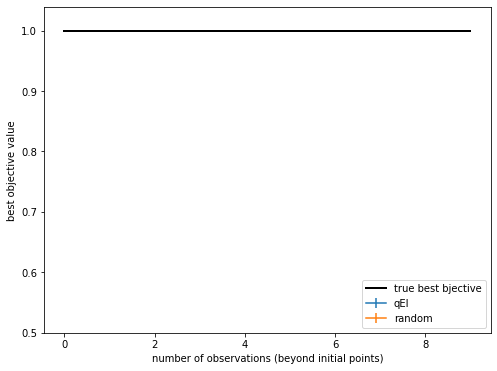

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

BATCH_SIZE = 3
num_qubits = 2
MAX_OP_NODES = 2

encoding_length = (num_qubits + 1) * MAX_OP_NODES
bounds = torch.tensor([[0.] * encoding_length, [1.0] * encoding_length], device=device, dtype=dtype)

N_TRIALS = 1
N_BATCH = 3
MC_SAMPLES = 2048

qnnbo = QNN_BO(
    num_qubits = num_qubits,
    MAX_OP_NODES = MAX_OP_NODES,
    N_TRIALS = N_TRIALS,
    N_BATCH = N_BATCH,
    BATCH_SIZE = BATCH_SIZE,
    MC_SAMPLES = MC_SAMPLES
)

best_observed_all_ei, best_random_all = qnnbo.optimize(bounds=bounds)

#qnnbo.plot(best_observed_all_ei, best_observed_all_nei, best_random_all)
to_plot = {'qEI': best_observed_all_ei,'random': best_random_all}
qnnbo.plot(to_plot)